## <h1><u>Data Science Intro - Pulsar Stars Classification</u><h1>

    

    
Ophir Shurany ID: 304867716


The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. These examples have all been checked by human annotators.

Attribute Information:

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile . This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve. These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

[HTRU 2 Summary](https://archive.ics.uci.edu/ml/datasets/HTRU2#)

17,898 total examples.

1,639 positive examples.

16,259 negative examples.

<h2><u>Imbalanced dataset predictions models</u><h2>

    1. Random Under Sampling
    2. Random Over Sampling
    3. SMOTE
    4. ADASYN
    5. Combine approach 
more info can be explained in [this link](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings('ignore')
plt.close('all')
import time
start_time = time.time()
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,fbeta_score
from sklearn.metrics import f1_score,v_measure_score,silhouette_score
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import jaccard_score,fowlkes_mallows_score,precision_recall_curve,log_loss
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.cm as cm
sns.set()
import time
start_time = time.time()

Using TensorFlow backend.


In [21]:
#%% Create dataframe
data = pd.read_csv("pulsar_stars.csv")
#view first 5 rows in df
data.head()
#presenting all columns, number of rows and type
data.info()
#feature statistics for numerical categories
data.describe().round(2)
#Majority class is 0 (Not a pulsar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86,0.09
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51,0.29
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98,0.00
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96,0.00
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06,0.00
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31,0.00
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00,1.00


In [3]:
cols = list(data.columns)
features = cols
features.remove('target_class')
# Normalization
X=data[features]
X = StandardScaler().fit_transform(X)
Y=data.target_class
#For this classification problem, I choose KNN 3 neighbors. 
model = KNeighborsClassifier(n_neighbors=3)

- Dummysampler is for measuring cross validation of the unbalanced data
- The Combine approach is called SMOTETomek, a class thats performs over-sampling using SMOTE and cleaning using Tomek links

In [4]:
class DummySampler:
    def sample(self, X, y):
        return X, y
    def fit(self, X, y):
        return self
    def fit_resample(self, X, y):
        return self.sample(X, y)
# prepare samplers
RUS=RandomUnderSampler()
ADASYN=ADASYN()
ROS= RandomOverSampler()
SMOTE=SMOTE()
Combine=SMOTETomek()
Samplers = []
Samplers.append(('Original', DummySampler()))
Samplers.append(('RUS', RUS))
Samplers.append(('ROS', ROS))
Samplers.append(('ADASYN', ADASYN))
Samplers.append(('SMOTE', SMOTE))
Samplers.append(('Combine', Combine))

The very simple metric to measure classification is basic accuracy i.e. ratio of correct predictions to the total number of samples in dataset. However, in the case of imbalanced classes this metric can be misguiding, as high metrics doesn’t show prediction capacity for the minority class.

I will now compare the results of the different models on the validation set using the following models:
- Accuracy*
- [F-Measure](https://en.wikipedia.org/wiki/F1_score)
- Precision
- Recall
- [ROC-AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

*Precision is an unsuitable measure of this problem, below I will explain the reasons why



****************accuracy**************
-----------Original---------
The number of samples in  Original  dataset is 17898
0    16259
1     1639
Name: target_class, dtype: int64
Ratio samples in  Original  dataset target values is 0.101
cross validation score -  Original: 0.978212 (0.011018)
-----------RUS---------
The number of samples in  RUS  dataset is 3278
1    1639
0    1639
Name: target_class, dtype: int64
Ratio samples in  RUS  dataset target values is 1.0
cross validation score -  RUS: 0.892992 (0.056382)
-----------ROS---------
The number of samples in  ROS  dataset is 32518
1    16259
0    16259
Name: target_class, dtype: int64
Ratio samples in  ROS  dataset target values is 1.0
cross validation score -  ROS: 0.936653 (0.007053)
-----------ADASYN---------
The number of samples in  ADASYN  dataset is 32378
0    16259
1    16119
Name: target_class, dtype: int64
Ratio samples in  ADASYN  dataset target values is 0.991
cross validation score -  ADASYN: 0.885740 (0.019135)
--------

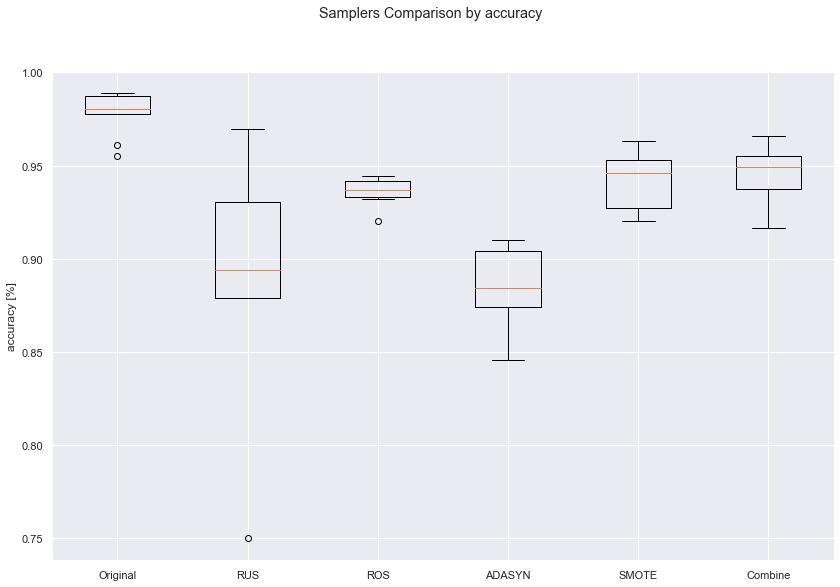

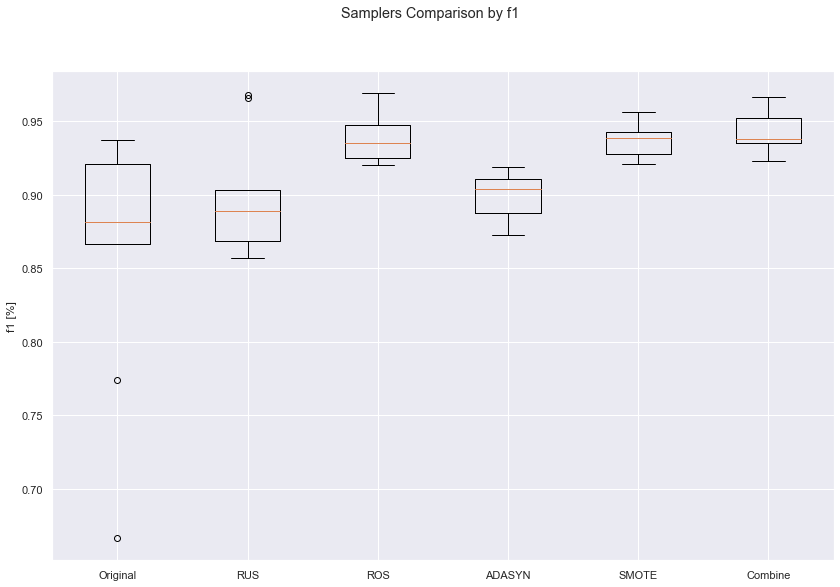

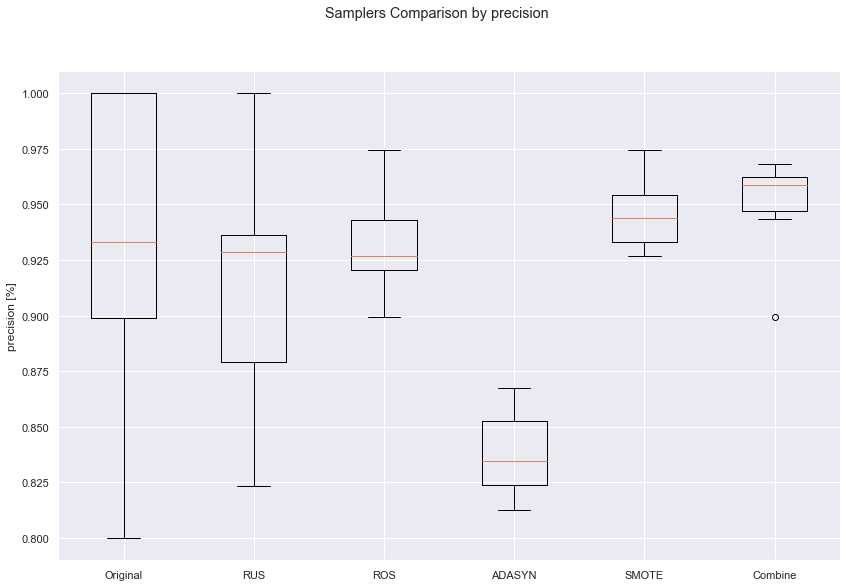

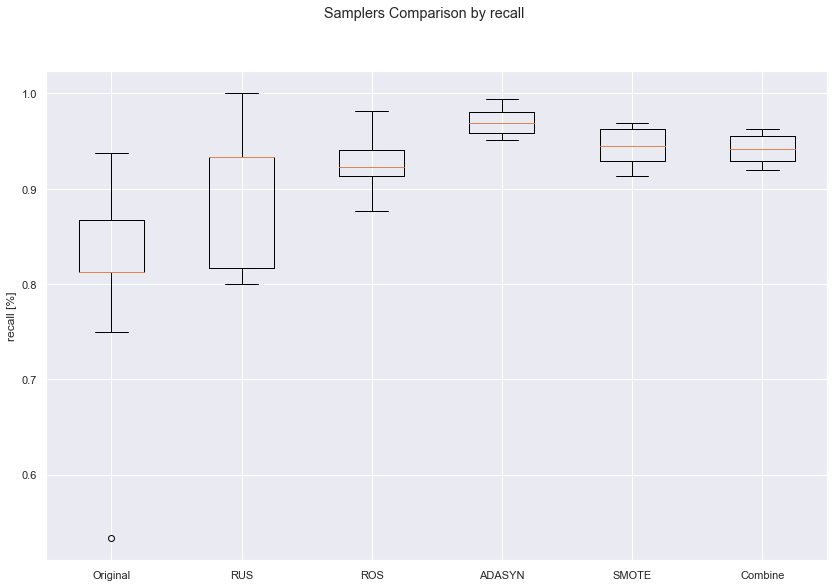

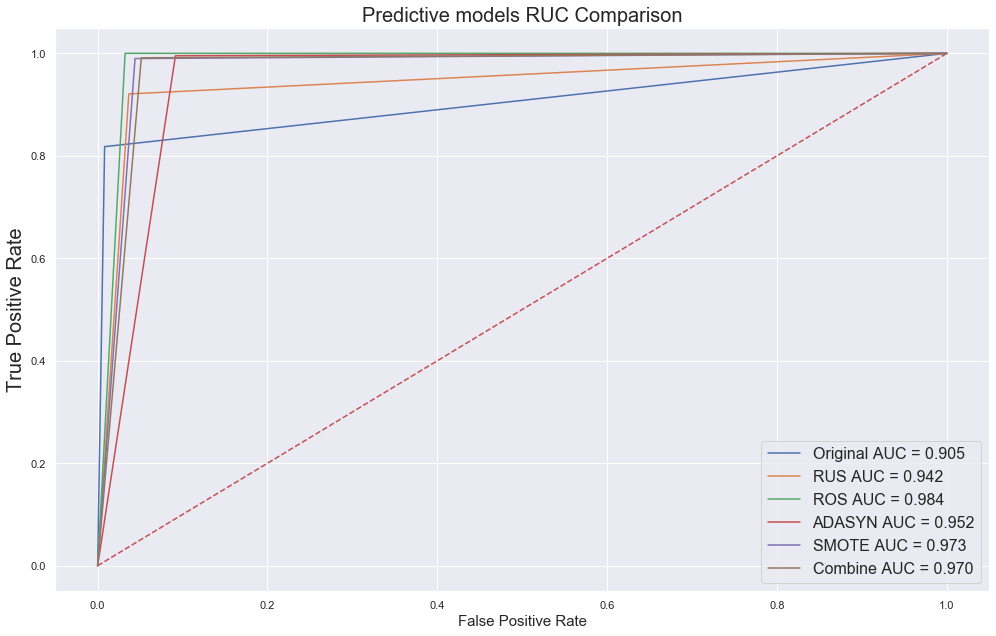

In [5]:
# evaluate each sampler in turn
score = ['accuracy', 'f1',"precision","recall"] #Different measures
RANDOM_STATE=0
for scoring in score:
    print("****************"+scoring+"**************")
    results = []
    names = []
    predictions=[]
    f1_score_tot=[];f2_score_tot=[]
    fpr_tot=[];tpr_tot=[];roc_auc_tot=[]
    for name, sampler in Samplers:
        print("-----------"+name+"---------")
        X_sampled, Y_sampled = sampler.fit_resample(X,Y)
        print("The number of samples in ",name," dataset is" ,X_sampled.shape[0])
        print(Y_sampled.value_counts())
        print("Ratio samples in ",name," dataset target values is",round(Y_sampled.value_counts()[1]/Y_sampled.value_counts()[0],3))
#Now I will randomly split the data so that 10% is saved for validation and 90% for training and test
        X_train_test, X_val, Y_train_test, Y_val =train_test_split(X_sampled, Y_sampled, test_size=0.1, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_train_test, Y_train_test, test_size=0.2, random_state=42)

        cv_results = cross_val_score(model, X_val, Y_val,cv=10, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print("cross validation score - ",msg)
        
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        predictions.append(y_pred)
        probs= model.predict_proba(X_test)
        preds = probs[:,1]
        #F2 score
        f1_measure=f1_score(y_test, y_pred)
        f1_score_tot.append(f1_measure)
        f2_score=fbeta_score(y_test, y_pred, beta=2)
        f2_score_tot.append(f2_score)
        #ROC-AUC
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        fpr_tot.append(fpr);tpr_tot.append(tpr);roc_auc_tot.append(roc_auc)
#    print(classification_report(y_test, model.predict(X_test),target_names=["no","yes"]))
#    CM=confusion_matrix(y_test, y_pred)
#    print(pd.DataFrame(CM, index = ["Predicted No","Predicted Yes"],
#              columns = ["Actual No","Actual Yes"]))
    # boxplot algorithm comparison
    fig1 = plt.figure(figsize=(14, 9))
    plt.tight_layout()
    fig1.suptitle('Samplers Comparison by '+scoring)
    ax1 = fig1.add_subplot(111)
    plt.boxplot(results)
    ax1.set_xticklabels(names)
    ax1.set_ylabel(scoring+" [%]")

plt.figure(figsize=(14, 9))
plt.plot([0, 1], [0, 1],'r--')
plt.title('Predictive models RUC Comparison',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.tight_layout()
for i in range(len(names)):
    plt.plot(fpr_tot[i], tpr_tot[i], label = names[i]+' AUC = %0.3f' % roc_auc_tot[i])
    plt.legend(loc = 'lower right', prop={'size': 16})

Samplers comparison by accuracy:
As mention before, the accuracy of unbalanced data (Original) has very high accuracy, compare to balanced datasets, but also has a very low values at F1 measure, mainly because low recall (can be seen in boxplot 4 **"Samplers comparison by recall"**)

For any $\beta$ score the equation is: $$ F_\beta = (1+\beta^2)\cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}\equiv  \frac{(1+\beta^2)\cdot True Positive}{(1+\beta^2)\cdot True Positive+\beta^2 \cdot False Negative + False Positive}  $$

for F2, $\beta = 2 $, and so $$ F_2 = 5\cdot \frac{precision \cdot recall}{(4 \cdot precision) + recall}\equiv  \frac{5\cdot True Positive}{5\cdot True Positive+4 \cdot False Negative + False Positive}  $$
It can be seen that F2 measure weighs recall higher than precision (by placing more emphasis on false negatives). 
This makes the F2 score more suitable in certain applications where it’s more important to classify correctly as many positive samples as possible, rather than maximizing the number of correct classifications, as in our case.

In [18]:
(pd.DataFrame(list(zip(f1_score_tot,f2_score_tot)),columns =['F1 measure', 'F2 measure'],index=names) .T).round(3)

,Original,RUS,ROS,ADASYN,SMOTE,Combine
F1 measure,0.861,0.940,0.984,0.955,0.974,0.971
F2 measure,0.835,0.928,0.994,0.979,0.983,0.983


As a conclusion I would recommend to use accuracy only if the classes are perfectly balanced, and otherwise use F2 and ROC-AUC. It is also useful to see ratio of positives and negative estimation via precision and recall.

<h2><u>Clustering the  original dataset<u><h2>

In [7]:
#%% Create dataframe
data = pd.read_csv("pulsar_stars.csv")
#view first 5 rows in df
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


We would for first part of our implementation, treat it as a unlabelled dataset and try to run clustering algorithms to find out the distinct group of data points namely:

1. [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis\)
2. [Agglomerative Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)
3. [KMeans](https://en.wikipedia.org/wiki/K-means_clustering)

PCA - Principal Component Analysis
It is a precursor step to any analysis that we may subject to our dataset. The above dataset has decent dimensional feature space consisting of 8 features. In such a high-dimensional space, Euclidean distances tend to become inflated and meaningless. This can severely impact our algorithms performance. Such a situation demands more data to train our model and this problem is called the 'Curse of Dimensionality'.

The PCA algorithm solves this problem by finding out the features that explain the maximum variance. So, instead of training our models over 8 features we will be training them over 2 features that explain the maximum variance.

 Together, the two components contain 78.0 % of the information


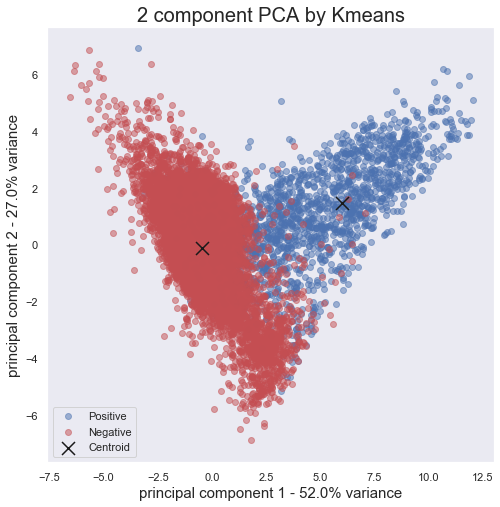

In [8]:
cols = list(data.columns)
features = cols
features.remove('target_class')
# Normalization
X=data[features]
X = StandardScaler().fit_transform(X)
Y=data.target_class
# Split dataset to 60% training and 40% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
# First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
#print(reduced_data[:10])  # print upto 10 elements
reduced_data.shape
principalDf = pd.DataFrame(data = reduced_data, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data[['target_class']]], axis = 1)
fig = plt.figure(figsize = (8,8))
PCA1='principal component 1 - '+str(100*round(pca.explained_variance_ratio_[0],2))+"% variance"
PCA2='principal component 2 - '+str(100*round(pca.explained_variance_ratio_[1],2))+"% variance"
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(PCA1, fontsize = 15)
ax.set_ylabel(PCA2, fontsize = 15)
ax.set_title('2 component PCA by Kmeans', fontsize = 20)
targets = [1,0]
colors = ['b', 'r']
pca.explained_variance_ratio_
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target_class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color,alpha=0.5)
ax.grid()
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(reduced_data)
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)
ax.legend(["Positive","Negative","Centroid"])
print(" Together, the two components contain",str(100*round(sum(pca.explained_variance_ratio_),2)),"% of the information")

[Average silhouette method](https://en.wikipedia.org/wiki/Silhouette_(clustering)) computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k.

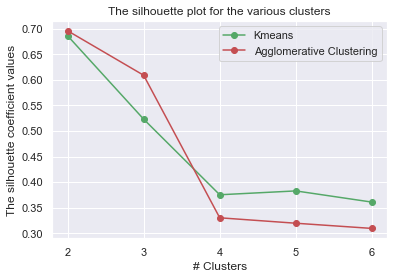

In [9]:
results_KMeans=[]
results_AC_n=[]
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    AC_n=AgglomerativeClustering(n_clusters=n_clusters)
    Kmeans_n = KMeans(n_clusters=n_clusters)
    clusterers=[Kmeans_n,AC_n]
    cluster_names=["KMeans","Agglomerative Clustering"]
    for clusterer in clusterers:
        cluster_labels = clusterer.fit_predict(reduced_data)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        if cluster_names[clusterers.index(clusterer)]=="KMeans":
            results_KMeans.append(silhouette_avg)
        else:
            results_AC_n.append(silhouette_avg)
fig = plt.figure()
ax = plt.axes()
ax.plot(range_n_clusters,results_KMeans,'-og', label='Kmeans')
ax.plot(range_n_clusters,results_AC_n,'-or', label='Agglomerative Clustering')
ax.set_title("The silhouette plot for the various clusters")
ax.set_ylabel("The silhouette coefficient values")
ax.set_xticks(range_n_clusters)
ax.set_xticklabels(range_n_clusters)
ax.set_xlabel("# Clusters")
ax.legend()
ax.grid(True)

he optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k=2.

Our data has groudtruth, we will use it to for the following external validity measures:

1. Pair-wise measure:

    1.1. [Rand statistics](https://en.wikipedia.org/wiki/Rand_index)
    
    1.2. [Jaccard coefficient](https://en.wikipedia.org/wiki/Jaccard_index)
    
    1.3. [Fowlkes-Mallows](https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index)
    
2. Matching based measures - [F-Measure](https://en.wikipedia.org/wiki/F1_score)
3. Entropy based measure - [Conditional Entropy](https://en.wikipedia.org/wiki/Conditional_entropy)

Total number of 5 different external validity measures.
        

In [10]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, Y, test_size=0.2, random_state=42)
AC_n=AgglomerativeClustering(n_clusters=2)
Kmeans_n = KMeans(n_clusters=2)
clusterers=[Kmeans_n,AC_n]
cluster_names=["KMeans","Agglomerative Clustering"]
fit_results=[]
for clusterer in clusterers:   
    clusterer.fit(X_train, y_train)
    y_pred=clusterer.fit_predict(X_test)
    Rand=adjusted_rand_score(y_test, y_pred)
    jaccard=jaccard_score(y_test, y_pred)
    FM=fowlkes_mallows_score(y_test, y_pred)
    cond_entropy=v_measure_score(y_test, y_pred)
    F_score=f1_score(y_test, y_pred)
    fit_results.append([Rand,jaccard,FM,F_score,cond_entropy])
results_table=pd.DataFrame(fit_results,
                           columns=['Rand', 'jaccard', 'FM',"cond_entropy","F_score"],
                           index=cluster_names).round(2)

In [14]:
results_table

,Rand,jaccard,FM,cond_entropy,F_score
KMeans,0.75,0.67,0.96,0.80,0.59
Agglomerative Clustering,0.52,0.41,0.94,0.58,0.41


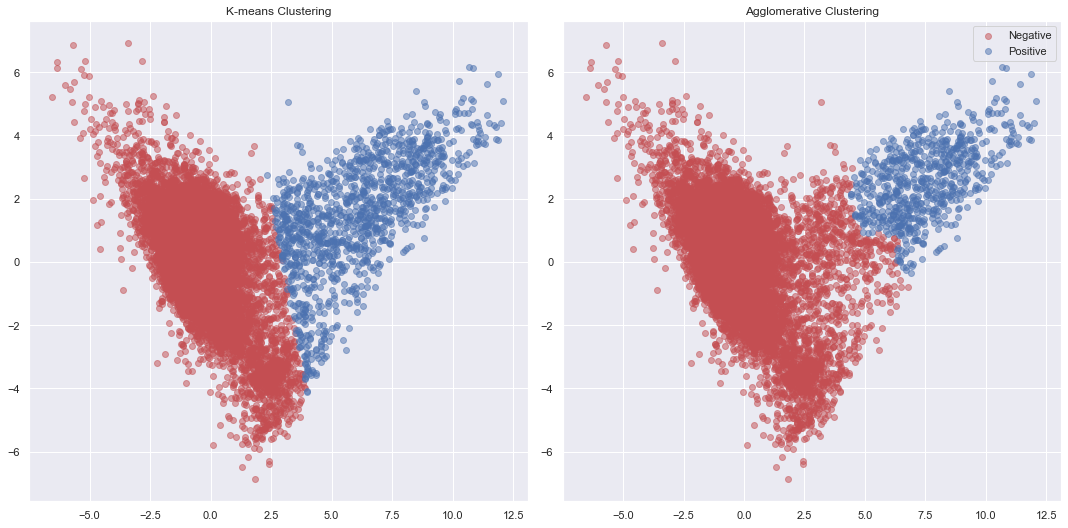

In [11]:
n=2
colors = ['r','b']
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))

km = KMeans(n_clusters= n , random_state=0)
y_km = km.fit_predict(reduced_data)

for i in range(n):
    ax1.scatter(reduced_data[y_km==i,0], reduced_data[y_km==i,1], c=colors[i], marker='o',alpha=0.5)   
ax1.set_title('K-means Clustering')


ac = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(reduced_data)

for i in range(n):
    ax2.scatter(reduced_data[y_ac==i,0], reduced_data[y_ac==i,1], c=colors[i], marker='o',alpha=0.5)
ax2.set_title('Agglomerative Clustering')
# Put a legend below current axis
plt.legend(["Negative","Positive"])
    
plt.tight_layout()

plt.show()


In [12]:
print("--- %s minutes ---" % (round(time.time()/60 - start_time/60,2)))

--- 5.62 minutes ---
